In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
# import scipy.stats.binom
# import scipy.stats.beta
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import time

start_date = '2020-03-01'
end_date ='2021-05-31'

a_qty = 20

a_fail_rate = .5

use_fail = False

unit_label = 'p/100m'

# survey data:
dfx= pd.read_csv('resources/checked_sdata_eos_2020_21.csv')

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description

# code material map
code_m_map = dfCodes.material

new_descriptions = { 'Industrial pellets (nurdles)': 'Pellets',
                    'Glass drink bottles, pieces': 'Glass bottles and pieces', 
                    'Food wrappers; candy, snacks': 'Food wrappers', 
                    'Food wrappers; candy, snacks': 'Food wrappers', 
                    'Foam packaging/insulation/polyurethane': 'Foam packaging for insulation', 
                    'Packaging films nonfood or unknown': 'Packaging films (not food-related)', 
                    'Lids unidentified': 'Other lids', 
                    'Tobacco; plastic packaging, containers': 'Plastic packaging for tobacco', 
                    'Fireworks paper tubes and fragments': 'Fireworks (paper parts)', 
                    'Diapers - wipes': 'Diapers and wipes', 
                    'Foamed items & pieces (non packaging/insulation) foamed sponge material': 'Foam items and pieces (not insulation)', 
                    'Labels, bar codes': 'Labels and bar codes', 
                    'Sanitary pads /panty liners/tampons and applicators': 'Sanitary pads, tampons and applicators', 
                    'Pellet mass from injection molding': 'Pellet mass', 
                    'Bags; plastic shopping/carrier/grocery and pieces': 'Plastic bags and pieces', 
                    'Lids for chemicals, detergents (non-food)': 'Lids for chemicals and detergents', 
                    'Coverings; plastic packaging, sheeting for protecting large cargo items': 'Plastic sheeting for large cargo items', 
                    'Construction material; bricks, pipes, cement': 'Construction materials (bricks, pipes, cement)', 
                    'Fireworks; rocket caps, exploded parts & packaging': 'Fireworks (rocket caps, exploded parts and packaging)', 
                    'Foamed EVA (flexible plastic) for crafts & watersports': 'Foamed EVA', 
                    'Metal bottle caps, lids & pull tabs from cans': 'Metal bottle caps, lids and pull tabs from cans', 
                    'Lid/cap rings from plastic bottles/containers': 'Lids and cap rings from plastic bottles', 
                    'Tissue, toilet paper, napkins, paper towels': 'Tissues, toilet paper and paper towels', 
                    'Cotton bud/swab sticks': 'Cotton buds and swab sticks', 
                    'Foil wrappers, aluminum foil': 'Aluminum foil', 
                    'Clothing, towels & rags': 'Clothing and rags', 
                    'Food containers single use foamed or plastic': 'Plastic food containers', 
                    'Plastic fragments angular <5mm': 'Angular plastic fragments (< 0.5 cm)', 
                    'Plastic fragments rounded <5mm': 'Round plastic fragments (< 0.5 cm)', 
                    'Foamed  plastic <5mm': 'Foam plastic (< 0.5 cm)', 
                    'Styrofoam < 5mm': 'Styrofoam fragments (< 0.5 cm)', 
                    'Glass or ceramic fragments > 2.5 cm': 'Glass and ceramic fragments (> 2.5 cm)',
                   }

to_replace = new_descriptions.keys()

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]


pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

new_label_keys = {
    1:"industrial",
    2:"buildings",
    3:"buildings",
    4:"buildings",
    5:"buildings",
    6:"transport",
    7:"transport",
    8:"transport",
    9:"buildings",
    10:"recreation",
    11:"agriculture",
    12:"agriculture",
    13:"agriculture",
    14:"agriculture",
    15:"agriculture",
    16:"agriculture",
    17:"woods",
    18:"agriculture",
    19:"woods",
    20:"woods",
    21:"woods",
    22:"woods",
    23:"water",
    24:"water",
    25:"unproductive",
    26:"unproductive",
    27:"unproductive"
}


def combineLandUseFeatures(buffer_data: pdtype = None, a_col: str = "AS18_27", new_col: str = "label",
                           new_label_keys: dict = new_label_keys) -> pdtype:
    """Assigns labels to land-use values according to <label_keys_new>. The new labels,
    when aggregated, create groups of land-use values that are similar. For exmaple,
    all the different types of buildings are labeled "buildings"
    
    Args:
        buffer_data: The land use values at a given radius
        a_col: The original column name that holds the labels for the land use values
        new_col: The new name of the column with the new labels
    
    Returns:
        The data frame with the new column and the new labels    
    """    
    
    buffer_data.rename(columns={"slug":"location", a_col:new_col}, inplace=True)
    buffer_data[new_col] = buffer_data[new_col].apply(lambda x : new_label_keys[x])
    
    return buffer_data

def adjustLandUse(buffer_data: pdtype = None, exclude_these: list = [], locations: list = []) -> pdtype:
    """The surface area of the water feature is removed from land-use calcluation. This
    can be bypassed. However, the study considers the surface area of the water as a fixed
    feature that exchanges with the different land-use features (which are not fixed).
    
    Args:
        buffer_data: The land use values at a given radius
        exclude_these: The labels to be excluded from the land use total
        locations: The locations of interest with buffer data
        
    Returns:
        The dataframe with the locations in locations and without the excluded labels      
    """
    data = buffer_data[~buffer_data.label.isin(exclude_these)]
    data = data[data.location.isin(locations)]
    
    return data

def addRoadLengthToBuffer(buffer_data: pdtype = None, location: str = None, 
                          road_lengths: pstype = None, scale: float = 1000.0):
    """Adds the length of road network to the % land use values.
    """
    
    road_length = road_lengths.loc[location]
    if scale != 1:
        road_length = round(road_length/scale, 1)
    
    buffer_data["roads"] = road_length
    
    return buffer_data

def addIntersectsToBuffer(buffer_data: pdtype = None, location: str = None, 
                          intersects: pstype = None, scale: float = 100.0):
    
    """Adds the number of river intersections to the buffer.
    
    The river intersections are the points where rivers join the body of water of interest
    """
    
    n_intersects = intersects.loc[location]
        
    buffer_data["intersects"] = n_intersects
    
    return buffer_data

def calculatePercentLandUse(buffer_data: pdtype = None, location: str = None, columns: list=[], label: str = "label",
                           add_intersects_roads: bool = True,  road_lengths: pstype = None, intersects: pstype = None) -> pd.Series:
    """Figures the % of total of each land-use feature for one location.
    
    Args:
        buffer_data: The land use values at a given radius
        location: The survey location of interest
    
    Returns:
        A pandas series of the % of total for each land-use feature in the index
    """
    
    try:
        # try to reitrieve the land use data for a location
        location_data = buffer_data[buffer_data.location == location][label].value_counts()
    except ValueError:
        print("The location data could not retrieved")
        raise
    
    # the sum of all land use features in the radius
    total = location_data.sum()
    # the amount of the area attributed to water (lakes and rivers)
    water = location_data.loc["water"]   
    # divide the land_use values by the total minus the amount attributed to water
    results = location_data/(total-water)
    results.fillna(0, inplace=True)
    
        
    
    # name the series
    results.name = location
    # the intersects and road-lengths are calculated seprately
    # if add_intersects and roads is true, attach them to the
    # the land use values
    if add_intersects_roads:
        results = addIntersectsToBuffer(buffer_data=results, location=location, intersects=intersects)
        results = addRoadLengthToBuffer(buffer_data=results, location=location, road_lengths=road_lengths)
    
    # add zero:
    zeros = [x for x in columns if x not in results.index]
    
    if len(zeros) > 0:
        
        for a_label in zeros:
            
            results.loc[a_label] = 0
    
    return results

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    def __init__(self, file_name: str = None, locations: list = [], columns: list={}):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        self.columns = columns
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, columns=self.columns, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse

# Lac Léman


## Introduction

To better control (eliminate) trash in the environment it is essential that the limited resources that are attributed to this domain be used as efficiently as possible. Correctly identifying zones of accumulation and or the objects that are accumulating in the watershed would enable more coordinated and precise actions between stakeholders. The process of identification needs to fulfill certain operating requirements to be effective:

* accurate
* repeatable
* scale-able (up and down)

Beach-litter data is `count` data. Gathered by volunteers following a protocol, the data is highly variable for many reasons. In most studies the median is less than the mean and in the case of the data for this study, the standard deviation is greater than the mean. Statistical tests dependent on linear relationships may not be appropriate, the guide from the JRC suggests using a Negative binomial distribution for modeling extreme events, the WRU and CEDRES use Generalized Linear Model of the Negative binomial distribution to define trend lines from one period to the next. In this way, litter count data is very similar to other environmental data that is based on observational studies.

### The nature of the data

Beach litter data is unique. The cost to collect it is extremely low and the method originates from the past-time of beach-combing, the hobby of going to the beach and finding what washes up on the shore, I remember going to Coyote Point in the south bay of San Francisco and walking the beach with my father and mother. As a rule, each item is collected and counted by a person. In this way the beach litter and its count are inextricably linked to a human experience with nature. In this experience the litter is an intruder. The difference between beach-combing and litter-counting is the effort and the intention. A person who counts beach litter does so for one reason: to get to the day where there is less to count.

### An exchange

Beach litter surveys detail the exchange of trash between the shoreline and the body of water. Some objects are carried by surface currents and deposited else where, other objects remain very close to the location where they were deposited. The density and surface area of the object the determinant factors in how likely it is to be transported, the dominant local hydrologic conditions ultimately decide where an object _beaches_.

### Easy to confirm or deny:

The cost of sampling is a big part of any long term monitoring effort. Comparing results from one period to the next is the reason samples are collected, it is __the method__ for determining progress towards a goal or measuring the effects of a treatment. Beach litter data can be collected by anyone who can count, write and operate a mobile phone. The training is concerned with defining the sample space and identifying objects in relation to the predefined categories in the JRC guide or OSPAR. Becasue of the low cost and ease of sampling testing a hypothesis or model is as simple as going to the beach.

### A beach-combers questions

These questions are based on the results of the Swiss Litter Survey of Lakes and Rivers.

1. How can the chance of finding an object be maximized?
2. How can exposure be minimized?

## Independent variables: _Land-use_

The data from the surveys gives the density and quantity of 217 different categories of objects for each sample location. There are 140 different sampling locations, each has a unique configuration of land use. In the first four chapters Spearmans Rho was used to determine the correlation between land-use attribute and survey results for a collection of objects. Recall that there are differences when the test is applied at the regional level and the national level, compare Rho for G27 for Lac Léman and all data.

### Extracting land-use features

The land-use features are extracted from the vecotrized land use layer of Swiss TLMRegio. The outline of each lake passes through a set of 500 m hexagons. Some of those hexagons contain sample locations:

*image of hex map*





The surface area of each land-use feature available in the map layer is calculated for each hexagon. The center of each hexagon is taken as a point of reference and then exported in .csv format.

*sample table with point and surface areas*

The ratio each land-use attribute is calculated as ratio of all land-use attributes (not including water).

*sample % of total land use*


### Estimating the road and river network

The values for the road and river network with a given radius are defined separately. The road network is the sum of the lengths of all roads, footpaths, freeways and forest roads within the area of interest. Note that the area attributed to roads given by the default map layer does not provide the same value. This is because of the way land use is estimated for each 100 m square. For example, if the center of a 100 m square has a road in it then the entire 100² m is attributed to the category roads (or railways). As a result only a portion of the road network is accounted for. 

To calculate the road network another map layer is used. The polylines for the roads are disolved into a single line, and the length of that line (divided by 1000) is the number of kilometers of road network for the area in question.

The river network includes the distance of the survey location to any river intersection within 2 km and the distance that the river travels inside the 1 500 m buffer around the survey location, the method is detailed in [Consider distance to river](distancetoriver)
__The land use for one location: example @ 1500 m__

### Retrieving the land-use attributes for one location

To calculate the land-use at one location for one radius. Requires indentifying the location of interest and the relevant file with the buffer data. These are minimum arguments to instantiate a `BufferData` object. Once the object is initiated the an adjusted buffer object is created. An adjusted-buffer-object is a datafram with between 690-720 rows. Each row corresponds to the land-use attribution for one of the 100 m squares within the 1500 m radius. 

The adjusted-buffer object can be used to exclude columns or values that are not of interest. If no columns are excluded the adjusted-buffer object contains all the land-use attributes for the location in question.

## The probability that a survey will exceed a given threshold

The purpose of Spearmans Rho is to identify possible monotonic relationships between variables and determine the direction of the relationship (positive or negative). Important information for sure, However those are not the questions that we are looking to answer. We can be much more specific given the data.

The scatter plot (below) demoonstrates the relationship. In this set of data there is positive correlation with buildings and cigarettes, the inverse for agricultural land use. Spearmans Rho can help verify what is already evident in the scatter plot. But then what? The results from Spearmans Rho are concerned with all the data, not a subset. For planning and assessments at the regional level, there will be far fewer samples than the national data set. Recall the difference between national and regional results. Which one is correct? Does this mean that the amount of buildings has no effect on sample results from the Léman region? Is this to be interpreted that the density of cigarette ends and candy wrappers is the same in rural and urban areas in the Léman region? One thing for sure is that Spearmans Rho is no help here.

```{figure} resources/images/land_use_correlation_20_0.png
---
name: rho_cigs_urban_rural
---
` `
```
{numref}`figure %s: <rho_cigs_urban_rural>` Left: survey totals cigarette ends with respect to % of land to buildings. = 0.39, p-value < .001. Right: survey totals cigarette ends with respect to % of land to aggriculture. = -0.31, p-value < .001.

#### Assumptions

1. Locations that have similar land-use attributes will have similar survey results
2. Surveys are independently distributed

Consider the probability of exceeding the average pcs-m of cigarette ends given the two landuse attributes. Each point represents _P_  or the proportion of times that a survey exceeded the avarage for a range of aggricultural or urban land use. 

The more agrcultural land use, the less likely a survey was to exceed the average, and the inverse for cities.

In [2]:
def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value

    return wrapper

def assignLanduseValue(sample: pstype=None, land_use: str=None) -> float:
    # returns the requested value of land use from the sample
    # if the requested land-use value is not present in the buffer
    # zero is returned
    try:
        result = sample.loc[land_use]
    except KeyError:
        result = 0
    
    return result

def cleanSurveyResults(data):
    # performs data cleaning operations on the
    # default data
    
    data['loc_date'] = list(zip(data.location, data["date"]))
    data['date'] = pd.to_datetime(data["date"])
    
    # get rid of microplastics
    mcr = data[data.groupname == "micro plastics (< 5mm)"].code.unique()
    
    # replace the bad code
    data.code = data.code.replace('G207', 'G208')
    data = data[~data.code.isin(mcr)]
    
    # walensee has no land-use values
    data = data[data.water_name_slug != 'walensee']   
    
    return data

class SurveyResults:
    """Creates a dataframe from a valid filename. Assigns the column names and defines a list of
    codes and locations that can be used in the CodeData class.
    """
    
    file_name = 'resources/checked_sdata_eos_2020_21.csv'
    columns_to_keep=[
        'loc_date',
        'location', 
        'river_bassin',
        'water_name_slug',
        'city',
        'w_t', 
        'intersects', 
        'code', 
        'pcs_m',
        'quantity'
    ]
        
    def __init__(self, data: str = file_name, clean_data: bool = True, columns: list = columns_to_keep, w_t: str = None):
        self.dfx = pd.read_csv(data)
        self.df_results = None
        self.locations = None
        self.valid_codes = None
        self.clean_data = clean_data
        self.columns = columns
        self.w_t = w_t
        
    def validCodes(self):
        # creates a list of unique code values for the data set    
        conditions = [
            isinstance(self.df_results, pdtype),
            "code" in self.df_results.columns
        ]

        if all(conditions):

            try:
                valid_codes = self.df_results.code.unique()
            except ValueError:
                print("There was an error retrieving the unique code names, self.df.code.unique() failed.")
                raise
            else:
                self.valid_codes = valid_codes
                
        
    def surveyResults(self):
        
        # if this method has been called already
        # return the result
        if self.df_results is not None:
            return self.df_results
        
        # for the default data self.clean data must be called        
        if self.clean_data is True:
            fd = cleanSurveyResults(self.dfx)
            
        # if the data is clean then if can be used directly
        else:
            fd = self.dfx
        
        # filter the data by the variable w_t
        if self.w_t is not None:
            fd = fd[fd.w_t == self.w_t]            
         
        # keep only the required columns
        if self.columns:
            fd = fd[self.columns]
        
        # assign the survey results to the class attribute
        self.df_results = fd
        
        # define the list of codes in this df
        self.validCodes()
        
        return self.df_results
    
    def surveyLocations(self):
        if self.locations is not None:
            return self.locations
        if self.df_results is not None:
            self.locations = self.dfResults.location.unique()
            return self.locations
        else:
            print("There is no survey data loaded")
            return None    

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    def __init__(self, file_name: str = None, locations: list = []):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse
    
class CodeData:
    
    def __init__(self, data: pdtype = None, code: str = None, **kwargs):
                
        self.data = data
        self.code = code
        self.code_data = None       
    
    def makeCodeData(self)->pdtype:
        
        if isinstance(self.code_data, pdtype):
            return self.code_data        
        
        conditions = [
            isinstance(self.data, pdtype)            
        ]
        
        if all(conditions):
            self.code_data = self.data[self.data.code == self.code]
            return self.code_data    
    
class CodeResults:   
        
    def __init__(self, code_data: pdtype = None, buffer: pdtype = None, code: str = None, 
                 method: callable = stats.spearmanr, **kwargs):        
        
        self.code_data = code_data
        self.buffer = buffer
        self.code = code
        self.method = method
        self.y = None
        self.x = None
        super().__init__()
    
        
    def landuseValueForOneCondition(self, land_use: str = None, locations: list = None)-> (np.array, np.array):
        
        x = self.code_data.pcs_m.values      
        y = [self.buffer[x].loc[land_use] for x in self.code_data.location.values]
        self.x, self.y = x, np.array(y)
                
        return self.x, self.y
    
    def rhoForALAndUseCategory(self, x: np.ndarray = None, y: np.ndarray = None) -> (float, float):
        # returns the asymptotic results if ranking based method is used        
        c, p = self.method(x, y)
        return c, p
    
    def getRho(self, x: np.array = None)-> float:
        # assigns y from self        
        result = self.method(x, self.y)
                       
        return result.correlation            
        
    def exactPValueForRho(self)-> float:
        # perform a permutation test instead of relying on 
        # the asymptotic p-value. Only one of the two inputs 
        # needs to be shuffled.
        p = stats.permutation_test((self.x,) , self.getRho, permutation_type='pairings', n_resamples=1000)
        
        return p


def makeBufferObject(file_name: str = "resources/buffer_output/luse_1500.csv", buffer_locations: list = None) -> (pdtype, pdtype):
    # Makes a buffer object by calling the BufferData class
    # calls the percentLandUse method and fills Nan values
    # returns the buffer_data object and pct land use values
    
    buffer_data = BufferData(file_name=file_name, locations=buffer_locations)
    pct_vals = buffer_data.percentLandUse()
    pct_vals.fillna(0, inplace=True)
    buffer_pcts = pct_vals.T
    buffer_pcts.reset_index(inplace=True, drop=False)
    buffer_pcts.rename(columns={"index":"location"}, inplace=True)
    
    
    return buffer_data, buffer_pcts



def asymptoticAndExactPvalues(data: pdtype = None, buffer: pdtype = None, code: 'str'=None, land_use: 'str'=None)-> dict:
    
    code_data = CodeData(data=data, code=code).makeCodeData()
    code_results = CodeResults(code_data=code_data, buffer=buffer)
    
    x, y = code_results.landuseValueForOneCondition(land_use=land_use)
    ci, pi = code_results.rhoForALAndUseCategory(x, y)
    px = code_results.exactPValueForRho()
    
    return {"code": code, "landuse": land_use, "a_symp": (round(pi, 3), ci), "exact": (round(px.pvalue, 3), px.statistic,)}

@timer
def rhoForOneBuffer(data: pdtype = None, buffer_file: str = "resources/buffer_output/luse_1500.csv", 
                    codes: list=None, land_use: list=None)->(list, pdtype, pdtype):
    
    buffer_locations = data.location.unique()
    new_buffer, buffer_vals = makeBufferObject(file_name=buffer_file, buffer_locations=buffer_locations)    
        
    rhovals_for_this_buffer = []
    for code in codes:
        for use in land_use:
            results = asymptoticAndExactPvalues(data=data, buffer=buffer_vals, code=code, land_use=use)
            rhovals_for_this_buffer.append(results)
    
    return rhovals_for_this_buffer, new_buffer, buffer_vals

def resultsDf(rhovals: pdtype = None, pvals: pdtype = None)-> pdtype:
    results_df = []
    for i, n in enumerate(pvals.index):
        arow_of_ps = pvals.iloc[i]
        p_fail = arow_of_ps[ arow_of_ps > 0.05]
        arow_of_rhos = rhovals.iloc[i]
        
        for label in p_fail.index:
            arow_of_rhos[label] = 0
        results_df.append(arow_of_rhos)
    
    return results_df

def rotateText(x):
    return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

def nObjectsPerLandUse(uses,surveys):
    results = {}
    for a_use in uses.index:
        total = surveys[surveys.code.isin(uses.loc[a_use])].quantity.sum()
        results.update({a_use:total})
    
    return pd.DataFrame(index=results.keys(), data=results.values(), columns=["total"])

# select locations
lakes = [
    "lago-maggiore",
    "lago-di-lugano",
    "zugersee",
    "bielersee",
    "zurichsee",
    "thunersee",
    "lac-leman",
    "brienzersee"
]

def mergeResultsAndBuffer(df, buffer_pcts, condition, bins=5):
    dfMerged = df.merge(buffer_pcts, on="location")
    dfMerged.rename(columns={"intersects_x":"intersects"} , inplace=True)
    if condition == "intersects":
        dfMerged["b_bin"] = dfMerged["intersects"]
    else:
        dfMerged["b_bin"] = pd.qcut(dfMerged[condition], bins, duplicates="drop")
    
    return dfMerged




def probabiityOfFindingX(data: pd.DataFrame = None, x: list=[], parameter="mean", condition: str = None):
    
    an_x = data[data.code.isin(x)].copy()
    
    if parameter == "mean":
        param = an_x.pcs_m.mean()
    else:
        param = an_x.pcs_m.median()
    
    n_exceeded = pd.DataFrame(an_x[an_x.pcs_m > param].value_counts(condition).sort_values())
    n_exceeded.rename(columns={"count":"k"}, inplace=True)
    
    n_samples = pd.DataFrame(an_x[condition].value_counts().sort_values())
    n_samples.index.name = condition
    n_samples.rename(columns={"count":"n"}, inplace=True)
    
    results = n_samples.merge(n_exceeded, on=condition)
    results["n-k"] = results["n"] - results["k"]
    results["k/(n-k)"] = results["k"]/results["n-k"]
    results["k/n"] = results["k"]/results["n"]
    
    
    
    # make aggregator
    return results.sort_index()

def makeBinsForLanduse(df, code, condition, bins):
    df = df[df.code.isin(code)].copy()
    data = mergeResultsAndBuffer(df, buffer_pcts, condition, bins=bins)
    resultsDf = probabiityOfFindingX(data=data, x=code, condition="b_bin")
    resultsDf.fillna(0, inplace=True)
    
    return resultsDf.reset_index()

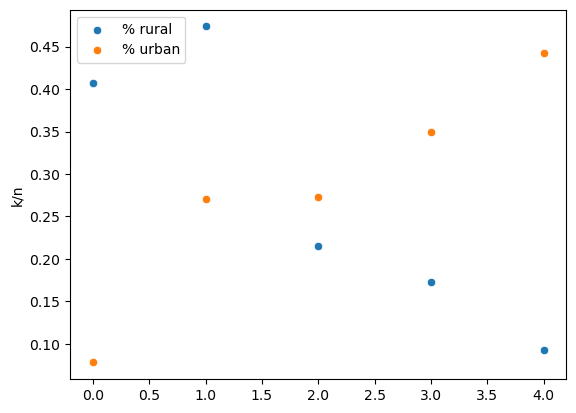

In [3]:
# collecting survey data
fdx = SurveyResults()
df = fdx.surveyResults()
# the locations on Neuchatel
lakes = ["bielersee", "neuenburgersee", "lac-leman", "zurichsee", "zugersee", "thunersee", "lago-di-maggiore", "lago-di-lugano", "brienzersee"]
    
df = df[df.water_name_slug.isin(lakes)]

locations = df.location.unique()

# the land use features we are interested in
land_use =["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]


# make a buffer object
the_buffer, buffer_pcts = makeBufferObject(buffer_locations=locations)

condition = land_use[4]

# 2 select an object
code = ["G27"]
resultsDfagg = makeBinsForLanduse(df, code, condition, 5)

condition = land_use[0]

# 2 select an object
resultsDfurb = makeBinsForLanduse(df, code, condition, 5)
fig, ax = plt.subplots()

sns.scatterplot(data=resultsDfagg, x=resultsDfagg.index, y="k/n", ax=ax, label="% rural")
sns.scatterplot(data=resultsDfurb, x=resultsDfurb.index, y="k/n", ax=ax, label="% urban")
plt.show()


In [4]:
resultsDfagg

,b_bin,n,k,n-k,k/(n-k),k/n
0,"(0.00433, 0.0513]",59,24,35,0.685714,0.406780
1,"(0.0513, 0.111]",57,27,30,0.900000,0.473684
2,"(0.111, 0.266]",51,11,40,0.275000,0.215686
3,"(0.266, 0.311]",58,10,48,0.208333,0.172414
4,"(0.311, 0.665]",54,5,49,0.102041,0.092593


In [5]:
lakeside_land_use = pd.read_csv("resources/lakelineshexs.csv")
llu = lakeside_land_use.copy()
lgrouped = llu.groupby(["OBJECTID", "OBJVAL", "x", "y"], as_index=False).area.sum()
lgrouped.rename(columns={"OBJECTID":"objectid", "OBJVAL":"objval"}, inplace=True)
lgrouped[lgrouped.objectid == 5611]

,objectid,objval,x,y,area
54,5611.0,Wald,6.633521,46.801500,231982.425
55,5611.0,Wald,6.639293,46.794794,89555.619


In [6]:

results["k"].sum()/resultsDf["n"].sum()

NameError: name 'results' is not defined

In [ ]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)

In [ ]:
%watermark --iversions -b -r